# Neural Style Transfer: Results evaluation

## Initial settings

In [12]:
%%capture
! pip install tensorflow_hub --upgrade

In [142]:
import json
import datetime
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow as tf
from PIL import Image
import re
import os
import numpy as np
import pandas as pd

INPUT_LOCAL_PATH = './data/input'
INPUT_CONTENT_PATH = f'{INPUT_LOCAL_PATH}/content-images'
INPUT_STYLE_PATH = f'{INPUT_LOCAL_PATH}/style-images'

OUTPUT_LOCAL_PATH = './data/output'
OUTPUT_DOWNLOADS_PATH = f'{OUTPUT_LOCAL_PATH}/model-downloads'
OUTPUT_RESULTS_PATH = f'{OUTPUT_LOCAL_PATH}/model-results'
OUTPUT_FAST_TRANSFER_PATH = f'{OUTPUT_LOCAL_PATH}/fast-style-transfer'

OUTPUT_BUCKET = 's3://sagemaker-studio-sr1encmpcxc/output'

LATEST_ESTIMATORS_FILE_PATH = "./latest_estimators.json"

## Load estimators metadata

In [9]:
def save_estimators_metadata(estimators: list[dict[str, str]]):
    """Save estimators as json"""
    # Save to dedicated path
    timestamp = datetime.datetime.now().strftime(("%Y%m%d-%Hh%Mm%Ss"))
    estimators_file_path = f"./estimators_metadata/estimators_{timestamp}.json"
    with open(estimators_file_path, "w") as f:
        json.dump(estimators, f)

    # Overwrite `latest estimators path`
    with open(LATEST_ESTIMATORS_FILE_PATH, "w") as f:
        json.dump(estimators, f)
        
def load_estimators() -> list[dict[str, str]]:
    with open(LATEST_ESTIMATORS_FILE_PATH, "r") as f:
        saved_estimators = json.load(f)
    return saved_estimators

##### Dummy estimators metadata

In [8]:
estimators = [
     {'content_image': '"sphynx_cat.jpg"',
      'style_image': '"adele_block_from_klimt.jpg"',
      'num_steps': '300',
      'num_iter': '4',
      'sagemaker_submit_directory': '"s3://sagemaker-studio-sr1encmpcxc/pytorch-style-transfer22-2023-04-11-07-53-03-342/source/sourcedir.tar.gz"',
      'sagemaker_program': '"style_transfer_pytorch.py"',
      'sagemaker_container_log_level': '20',
      'sagemaker_job_name': '"pytorch-style-transfer22-2023-04-11-07-53-03-342"',
      'sagemaker_region': '"us-east-1"'},
     {'content_image': '"sphynx_cat.jpg"',
      'style_image': '"Vassily_Kandinsky.jpeg"',
      'num_steps': '300',
      'num_iter': '4',
      'sagemaker_submit_directory': '"s3://sagemaker-studio-sr1encmpcxc/pytorch-style-transfer22-2023-04-11-09-06-19-859/source/sourcedir.tar.gz"',
      'sagemaker_program': '"style_transfer_pytorch.py"',
      'sagemaker_container_log_level': '20',
      'sagemaker_job_name': '"pytorch-style-transfer22-2023-04-11-09-06-19-859"',
      'sagemaker_region': '"us-east-1"'}
]

## Visualize Content - Style - Generated image

In [10]:
def load_style_transfer_images(estimators_metadata):
    
    nrows = len(estimators_metadata) 
    ncols = 3
    fig, axs = plt.subplots(nrows, ncols,  figsize=(15, 6*nrows))
    fig.subplots_adjust(wspace=0.05)
    for hyperparams, axes in zip(estimators_metadata, axs):
    
        content_img_name = eval(hyperparams['content_image'])
        style_img_name = eval(hyperparams['style_image'])
        estimator_name = eval(hyperparams['sagemaker_job_name'])
        output_images_dir = f'{OUTPUT_DOWNLOADS_PATH}/{estimator_name}'

        # Define input paths for the images
        content_image_path = f'{INPUT_CONTENT_PATH}/{content_img_name}'
        style_image_path = f'{INPUT_STYLE_PATH}/{style_img_name}'
        output_image_path = final_image_path(output_images_dir, eval(hyperparams['num_iter']))

        # Load images
        images = [
            ('Content', Image.open(content_image_path)),
            ('Style', Image.open(style_image_path)),
            ('Generated Image', Image.open(output_image_path))
        ]

        # Plot images
        for (img_type, img_data), ax in zip(images, axes):
            ax.imshow(img_data)
            ax.axis('off')
            ax.set_title(img_type)
    
    fig.subplots_adjust(wspace=0.01)
    fig.savefig('test.jpg', dpi=100, bbox_inches='tight')
  

def final_image_path(output_images_dir: str, num_iter: int) -> str:
    return f'{output_images_dir}/result-iter-{num_iter - 1}.jpg'

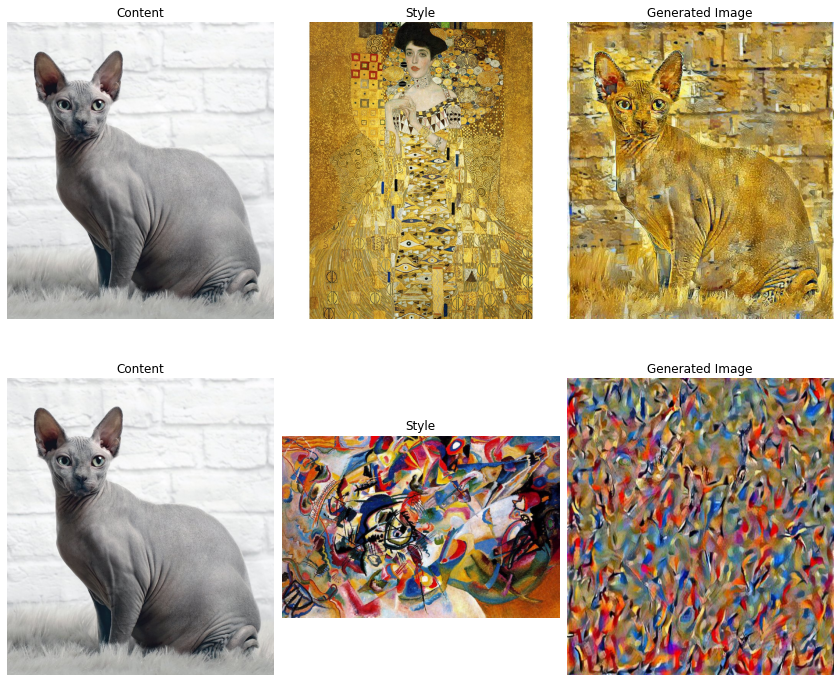

In [18]:
estimators_10x = estimators
load_style_transfer_images(estimators_10x)

## Visualize Neural Transfer Style Image vs Fast Transfer Style Image

In [14]:
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

In [32]:
def load_img(path_to_img):
      """
      Loads an image from a file path and returns a tensor of shape (1, height, width, channels)
      with pixel values scaled to the range [0, 1].
      The input image size is limited to a manageable size that can be processed efficiently by the model
      """
      img = tf.io.read_file(path_to_img)
      img = tf.image.decode_image(img, channels=3)

      # Convert pixel values to `float32` and scale values to range [0, 1]
      img = tf.image.convert_image_dtype(img, tf.float32) 

      # Set max. dimension (either width or height)
      max_dim = 512 

      # Resize image preserving aspect ratio
      shape = tf.cast(tf.shape(img)[:-1], tf.float32)
      long_dim = max(shape)
      scale = max_dim / long_dim  
      new_shape = tf.cast(shape * scale, tf.int32)
      img = tf.image.resize(img, new_shape) 

      # Add extra dimension to the tensor (batch size)
      img = img[tf.newaxis, :]
      return img

def tensor_to_image(tensor):
      """Convert tensor to image.
      PIL (Python Imaging Library) expects the pixel values in an image to be represented as
      unsigned 8-bit integers with values between 0 and 255
      """
      # Convert pixel values in the tensor to the range [0,255]
      tensor = tensor*255
      # Convert to a numpy array with unsigned 8-bit integers
      tensor = np.array(tensor, dtype=np.uint8)

      # If the tensor has a batch dimension, remove it
      if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]

      return Image.fromarray(tensor)

In [146]:
def load_fast_transfer_image(estimator_metadata) -> str:
    """Loads the Fast Style Transfer image corresponding to an estimator.
    If the image does not exist, it is created and saved.
    """
    content_img_name = eval(estimator_metadata['content_image'])
    style_img_name = eval(estimator_metadata['style_image'])

    # Define output path for the fast transfer image
    image_name = fast_transfer_image_name(content_img_name, style_img_name)
    output_image_path = f'{OUTPUT_FAST_TRANSFER_PATH}/{image_name}'

    # If the image does not exist, create it
    if  not os.path.isfile(output_image_path):

        content_image_path = f'{INPUT_CONTENT_PATH}/{content_img_name}'
        style_image_path = f'{INPUT_STYLE_PATH}/{style_img_name}'

        # Create stylized image with TF HUB
        content_image = load_img(content_image_path)
        style_image= load_img(style_image_path)
        stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]

        # Save image
        tensor_to_image(stylized_image) .save(output_image_path)

    return output_image_path

def fast_transfer_image_name(content_img_name: str, style_img_name: str):
    content_img_name = re.sub(r'[^a-zA-Z0-9]', '', content_img_name)
    style_img_name = re.sub(r'[^a-zA-Z0-9]', '', style_img_name)
    return f'{content_img_name}_and_{style_img_name}.jpg'

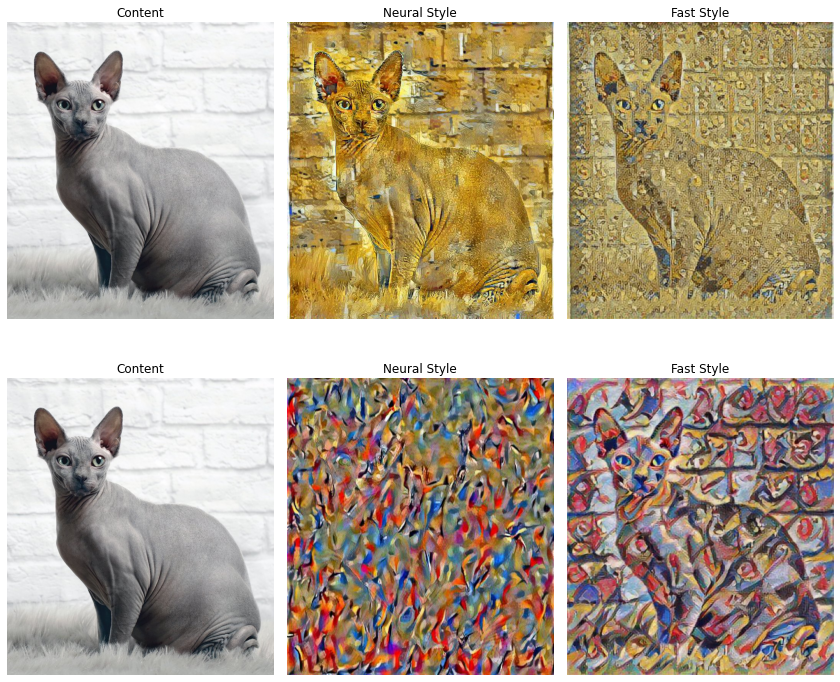

In [145]:
def compare_style_transfer_images(estimators_metadata):
    
    nrows = len(estimators_metadata) 
    ncols = 3
    fig, axs = plt.subplots(nrows, ncols,  figsize=(15, 6*nrows))
    fig.subplots_adjust(wspace=0.05)
    for hyperparams, axes in zip(estimators_metadata, axs):
    
        content_img_name = eval(hyperparams['content_image'])
        estimator_name = eval(hyperparams['sagemaker_job_name'])
        output_images_dir = f'{OUTPUT_DOWNLOADS_PATH}/{estimator_name}'

        # Define input paths for the images
        content_image_path = f'{INPUT_CONTENT_PATH}/{content_img_name}'
        output_image_path = final_image_path(output_images_dir, eval(hyperparams['num_iter']))
        fast_transfer_image_path = load_fast_transfer_image(hyperparams)

        # Load images to plot
        images = [
            ('Content', Image.open(content_image_path)),
            ('Neural Style', Image.open(output_image_path)),
            ('Fast Style', Image.open(fast_transfer_image_path))
        ]

        # Plot images
        for (img_type, img_data), ax in zip(images, axes):
            ax.imshow(img_data)
            ax.axis('off')
            ax.set_title(img_type)
    
    fig.subplots_adjust(wspace=0.01)
    fig.savefig('test.jpg', dpi=100, bbox_inches='tight')
    
    
estimators_10x = estimators
compare_style_transfer_images(estimators_10x)

## Create image quality metrics (Fast vs Neural)

In [147]:
from collections import defaultdict 

In [168]:
def calculate_mse(content_image, stylized_image):
    content_shape = (content_image.shape[1], content_image.shape[2])
    stylized_image_resized = tf.image.resize(stylized_image, content_shape)

    return tf.add_n([tf.reduce_mean((stylized_image_resized-content_image)**2)]).numpy()


def calculate_ssim(content_image, stylized_image):
    content_shape = (content_image.shape[1], content_image.shape[2])
    stylized_image_resized = tf.image.resize(stylized_image, content_shape)

    return tf.image.ssim(content_image, stylized_image_resized, max_val=1).numpy()[0]


def produce_metrics_results(estimators_metadata):
    
    metrics = defaultdict(list)
    
    for hyperparams in estimators_metadata:
        
        content_img_name = eval(hyperparams['content_image'])
        style_img_name = eval(hyperparams['style_image'])
        estimator_name = eval(hyperparams['sagemaker_job_name'])
        output_images_dir = f'{OUTPUT_DOWNLOADS_PATH}/{estimator_name}'
        
        # Get input paths
        content_image_path = f'{INPUT_CONTENT_PATH}/{content_img_name}'
        output_image_path = final_image_path(output_images_dir, eval(hyperparams['num_iter']))
        fast_transfer_image_path = load_fast_transfer_image(hyperparams)
        
        # Load images to compare
        images = {
            'Content': load_img(content_image_path),
            'Neural Style': load_img(output_image_path),
            'Fast Style': load_img(fast_transfer_image_path)
        }
        

        metrics['estimator_name'].append(estimator_name)
        metrics['MSE_Neural_Style'].append(
            calculate_mse(images['Content'], images['Neural Style'])
        )
        metrics['MSE_Fast_Style'].append(
            calculate_mse(images['Content'], images['Fast Style'])
        )
        metrics['SSIM_Neural_Style'].append(
            calculate_ssim(images['Content'], images['Neural Style'])
        )
        metrics['SSIM_Fast_Style'].append(
            calculate_ssim(images['Content'], images['Fast Style'])
        )
    
    return pd.DataFrame(metrics)
        
metrics_df = produce_metrics_results(estimators*5)        
metrics_df      
        
# Bar plot

./data/input/content-images/sphynx_cat.jpg
./data/output/model-downloads/pytorch-style-transfer22-2023-04-11-07-53-03-342/result-iter-3.jpg
./data/output/fast-style-transfer/sphynxcatjpg_and_adeleblockfromklimtjpg.jpg
./data/input/content-images/sphynx_cat.jpg
./data/output/model-downloads/pytorch-style-transfer22-2023-04-11-09-06-19-859/result-iter-3.jpg
./data/output/fast-style-transfer/sphynxcatjpg_and_VassilyKandinskyjpeg.jpg
./data/input/content-images/sphynx_cat.jpg
./data/output/model-downloads/pytorch-style-transfer22-2023-04-11-07-53-03-342/result-iter-3.jpg
./data/output/fast-style-transfer/sphynxcatjpg_and_adeleblockfromklimtjpg.jpg
./data/input/content-images/sphynx_cat.jpg
./data/output/model-downloads/pytorch-style-transfer22-2023-04-11-09-06-19-859/result-iter-3.jpg
./data/output/fast-style-transfer/sphynxcatjpg_and_VassilyKandinskyjpeg.jpg
./data/input/content-images/sphynx_cat.jpg
./data/output/model-downloads/pytorch-style-transfer22-2023-04-11-07-53-03-342/result-ite

,estimator_name,MSE_Neural_Style,MSE_Fast_Style,SSIM_Neural_Style,SSIM_Fast_Style
0,pytorch-style-transfer22-2023-04-11-07-53-03-342,0.135668,0.109747,0.390617,0.236785
1,pytorch-style-transfer22-2023-04-11-09-06-19-859,0.187671,0.133048,0.153005,0.270023
2,pytorch-style-transfer22-2023-04-11-07-53-03-342,0.135668,0.109747,0.390617,0.236785
3,pytorch-style-transfer22-2023-04-11-09-06-19-859,0.187671,0.133048,0.153005,0.270023
4,pytorch-style-transfer22-2023-04-11-07-53-03-342,0.135668,0.109747,0.390617,0.236785
5,pytorch-style-transfer22-2023-04-11-09-06-19-859,0.187671,0.133048,0.153005,0.270023
6,pytorch-style-transfer22-2023-04-11-07-53-03-342,0.135668,0.109747,0.390617,0.236785
7,pytorch-style-transfer22-2023-04-11-09-06-19-859,0.187671,0.133048,0.153005,0.270023
8,pytorch-style-transfer22-2023-04-11-07-53-03-342,0.135668,0.109747,0.390617,0.236785
9,pytorch-style-transfer22-2023-04-11-09-06-19-859,0.187671,0.133048,0.153005,0.270023


In [162]:
content_image = load_img("./data/input/content-images/sphynx_cat.jpg")
stylized_image_github = load_img("./data/output/model-downloads/pytorch-style-transfer22-2023-04-11-07-53-03-342/result-iter-3.jpg")
stylized_image = load_img("./data/output/fast-style-transfer/sphynxcatjpg_and_adeleblockfromklimtjpg.jpg")

In [159]:
content_image.shape

TensorShape([1, 512, 459, 3])

In [160]:
stylized_image.shape

TensorShape([1, 512, 460, 3])

In [165]:
calculate_mse(content_image, stylized_image)

0.10974706

In [50]:
tf.math.reduce_max(content_image).numpy(), tf.math.reduce_min(content_image).numpy()

(1.0, 0.0033552342)

In [166]:
calculate_mse(content_image, stylized_image), calculate_ssim(content_image, stylized_image)

(0.10974706, 0.23678511)

In [167]:
calculate_mse(content_image, stylized_image_github), calculate_ssim(content_image, stylized_image_github)

(0.13566816, 0.39061713)

In [42]:
tensor_to_image(stylized_image).save("cat_klimt_fast_style_transfer.jpg")

## Metrics (old)

In [13]:
#!/usr/bin/env python

from skimage.metrics import structural_similarity as ssim
import numpy as np
import cv2
import argparse

def options():
 parser = argparse.ArgumentParser(description="Read image metadata")
 parser.add_argument("-o", "--first", help="Input image file.", required=True)
 parser.add_argument("-c", "--second", help="Input image file.", required=True)
 args = parser.parse_args()
 return args

def mse(imageA, imageB):
 # the 'Mean Squared Error' between the two images is the sum of the squared difference between the two images
 mse_error = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
 mse_error /= float(imageA.shape[0] * imageA.shape[1])
	
 # return the MSE. The lower the error, the more "similar" the two images are.
 return mse_error

def compare(imageA, imageB):
 # Calculate the MSE and SSIM
 m = mse(imageA, imageB)
 s = ssim(imageA, imageB)

 # Return the SSIM. The higher the value, the more "similar" the two images are.
 return s

def main(): 

 # Get options
 #args = options()

 # Import images
 image1 = cv2.imread(args.first)
 image2 = cv2.imread(args.second, 1)

 # Convert the images to grayscale
 gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
 gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

 # Check for same size and ratio and report accordingly
 ho, wo, _ = image1.shape
 hc, wc, _ = image2.shape
 ratio_orig = ho/wo
 ratio_comp = hc/wc
 dim = (wc, hc)

 if round(ratio_orig, 2) != round(ratio_comp, 2):
  print("\nImages not of the same dimension. Check input.")
  exit()

 # Resize first image if the second image is smaller
 elif ho > hc and wo > wc:
  print("\nResizing original image for analysis...")
  gray1 = cv2.resize(gray1, dim)

 elif ho < hc and wo < wc:
  print("\nCompressed image has a larger dimension than the original. Check input.")
  exit()

 if round(ratio_orig, 2) == round(ratio_comp, 2):
  mse_value = mse(gray1, gray2)
  ssim_value = compare(gray1, gray2)
  print("MSE:", mse_value)
  print("SSIM:", ssim_value)


main()

NameError: name 'args' is not defined

In [9]:
! pip install scikit-image  opencv-python

     |████████████████████████████████| 91.1 MB 134.5 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for opencv-python: filename=opencv_python-4.7.0.72-cp38-cp38-macosx_10_15_x86_64.whl size=26923723 sha256=3450c6a39a63335b2363a6aafe4c2b73d50578296452678a5f2aeeb16acca17b
  Stored in directory: /Users/cagw/Library/Caches/pip/wheels/b3/d1/a4/c1da6d180c2a5c587b8c1ed5657abc7a125282cddf95bf55c8
Successfully built opencv-python


In [63]:
from sagemaker.estimator import Estimator
estimator = Estimator.attach("pytorch-style-transfer22-2023-04-11-09-06-19-859") 


2023-04-11 10:22:10 Starting - Preparing the instances for training
2023-04-11 10:22:10 Downloading - Downloading input data
2023-04-11 10:22:10 Training - Training image download completed. Training in progress.
2023-04-11 10:22:10 Uploading - Uploading generated training model
2023-04-11 10:22:10 Completed - Training job completed


In [74]:
session = sagemaker.Session()


In [82]:
estimator._current_job_name

'pytorch-style-transfer22-2023-04-11-09-06-19-859'

In [101]:
from time import sleep
sleep(1)

In [141]:
import boto3
from time import sleep

sm = boto3.Session().client('sagemaker')

estimator_names = ['pytorch-style-transfer22-2023-04-11-09-06-19-859']
incomplete_jobs = set(estimator_names)
completed_jobs = set()

while incomplete_jobs:
    
    print('Looping over incomplete jobs:',incomplete_jobs)
    for job_name in incomplete_jobs:
        
        status = sm.describe_training_job(TrainingJobName="pytorch-style-transfer22-2023-04-11-09-06-19-859")['TrainingJobStatus']
        
        if status == 'Completed':
            print(f'Completed job: {job_name}')
            #save_estimator_hyperparams(estimator)
            #download_output_images(estimator)
            #save_experiment(estimator, hyperparams_keys)
            completed_jobs.add(job_name)
            
    incomplete_jobs = incomplete_jobs - completed_jobs
    sleep(1)
        

Looping over incomplete jobs: {'pytorch-style-transfer22-2023-04-11-09-06-19-859'}
Completed job: pytorch-style-transfer22-2023-04-11-09-06-19-859


In [98]:
incomplete_jobs.remove('pytorch-style-transfer22-2023-04-11-09-06-19-859')

In [80]:
[c for c in dir(estimator) if 'name' in c]

['_compilation_job_name',
 '_current_job_name',
 '_ensure_base_job_name',
 '_get_or_create_name',
 'base_job_name',
 'code_channel_name',
 'model_channel_name']

In [66]:
import sagemaker
sagemaker.describe_training_job

AttributeError: module 'sagemaker' has no attribute 'describe_training_job'

In [75]:

sm.describe_training_job(TrainingJobName="pytorch-style-transfer22-2023-04-11-09-06-19-859")['TrainingJobStatus']

'Completed'

In [76]:
sm.describe_training_job(TrainingJobName="pytorch-style-transfer22-2023-04-11-09-06-19-859")

{'TrainingJobName': 'pytorch-style-transfer22-2023-04-11-09-06-19-859',
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:798714931926:training-job/pytorch-style-transfer22-2023-04-11-09-06-19-859',
 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-studio-sr1encmpcxc/output/pytorch-style-transfer22-2023-04-11-09-06-19-859/output/model.tar.gz'},
 'TrainingJobStatus': 'Completed',
 'SecondaryStatus': 'Completed',
 'HyperParameters': {'content_image': '"sphynx_cat.jpg"',
  'num_iter': '4',
  'num_steps': '300',
  'sagemaker_container_log_level': '20',
  'sagemaker_job_name': '"pytorch-style-transfer22-2023-04-11-09-06-19-859"',
  'sagemaker_program': '"style_transfer_pytorch.py"',
  'sagemaker_region': '"us-east-1"',
  'sagemaker_submit_directory': '"s3://sagemaker-studio-sr1encmpcxc/pytorch-style-transfer22-2023-04-11-09-06-19-859/source/sourcedir.tar.gz"',
  'style_image': '"Vassily_Kandinsky.jpeg"'},
 'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.us-east-1.amazo